## STOCK PERFORMANCE ANALYSIS
#### GRACE ORIZU
#### TDI CAPSTONE PYTHON

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

#### Import Dataset

In [9]:
df = pd.read_csv(r"C:\Users\Grace\OneDrive\Desktop\PYTHON\stock_data_july_2025.csv")

In [13]:
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:\n", df.head())
print("\nData Info:\n")
df.info()

Dataset Shape: (4346, 14)

First 5 rows:
          Date Ticker  Open Price  Close Price  High Price  Low Price  \
0  2025-06-01   AAPL      185.96       187.79      188.85     183.74   
1  2025-06-01   ABBV      189.63       193.64      194.31     188.03   
2  2025-06-01    ABT      118.79       120.08      120.53     118.01   
3  2025-06-01   ADBE      584.51       567.78      587.97     561.25   
4  2025-06-01    ADP      253.46       255.60      258.59     249.91   

   Volume Traded    Market Cap  PE Ratio  Dividend Yield    EPS  52 Week High  \
0       42257183  2.931356e+12     28.37            0.49   6.62        248.20   
1       33074970  3.289227e+11     16.74            3.51  11.57        210.83   
2       17130934  2.001333e+11     19.39            1.84   6.19        140.79   
3       11080360  2.460380e+11     43.29            0.00  13.12        727.11   
4       10319559  1.052471e+11     29.92            2.04   8.54        303.75   

   52 Week Low      Sector  
0       1

### Basic cleaning & type conversion

In [15]:
# Convert Date column
df['Date'] = pd.to_datetime(df['Date'])

In [17]:
# Standardize column names (strip)
df.columns = [c.strip() for c in df.columns]

In [19]:
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Date              0
Ticker            0
Open Price        0
Close Price       0
High Price        0
Low Price         0
Volume Traded     0
Market Cap        0
PE Ratio          0
Dividend Yield    0
EPS               0
52 Week High      0
52 Week Low       0
Sector            0
dtype: int64


In [21]:
df.drop_duplicates(inplace=True)


In [23]:
df['Month'] = df['Date'].dt.month_name()

print("\nMonths present & counts:")
print(df['Month'].value_counts())


Months present & counts:
Month
June    2460
July    1886
Name: count, dtype: int64


In [45]:
# Keep important columns as numeric (coerce errors -> NaN)
numeric_cols = [
    'Open Price', 'Close Price', 'High Price', 'Low Price',
    'Volume Traded', 'Market Cap', 'PE Ratio', 'Dividend Yield',
    'EPS', '52 Week High', '52 Week Low'
]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [47]:
# Drop only rows missing critical identifiers or prices
df_before = df.shape[0]
df = df.dropna(subset=['Date', 'Ticker', 'Open Price', 'Close Price', 'Sector'])
print(f"\nDropped {df_before - df.shape[0]} rows missing Date/Ticker/Open/Close/Sector.")


Dropped 0 rows missing Date/Ticker/Open/Close/Sector.


In [49]:
# Trim string columns
df['Ticker'] = df['Ticker'].astype(str).str.strip()
df['Sector'] = df['Sector'].astype(str).str.strip()

####  FEATURE ENGINEERING (Daily, Monthly returns, volatility, flags)

In [51]:
# Daily Return (%) — use open vs close (intraday)
df['Daily Return (%)'] = (df['Close Price'] - df['Open Price']) / df['Open Price'] * 100


In [53]:
# Monthly return per ticker: (last_close_in_month - first_close_in_month)/first_close *100
monthly = (
    df.sort_values(['Ticker','Date'])
      .groupby(['Ticker','Month'])
      .agg(first_close=('Close Price','first'),
           last_close=('Close Price','last'),
           days_count=('Close Price','count'))
      .reset_index()
)
monthly['Monthly Return (%)'] = (monthly['last_close'] - monthly['first_close']) / monthly['first_close'] * 100

In [55]:
# Volatility per ticker per month (std dev of Daily Return)
vol_ticker_month = (df.groupby(['Ticker','Month'])['Daily Return (%)']
                     .std()
                     .reset_index(name='Volatility (%)'))

In [37]:
# Latest snapshot per ticker (useful for Market Cap, PE, Dividend status)
latest = df.sort_values(['Ticker','Date']).groupby('Ticker').last().reset_index()

In [39]:
# Dividend-paying flag (use latest dividend yield > 0)
latest['Pays Dividend'] = latest['Dividend Yield'].fillna(0) > 0
monthly = monthly.merge(latest[['Ticker','Pays Dividend']], on='Ticker', how='left')

In [41]:
# Identify dividend-paying stocks
df['Dividend_Paying'] = df['Dividend Yield'] > 0 

#### Research Analytical Questions

#### 1. Which sectors performed best in June vs July 2025?

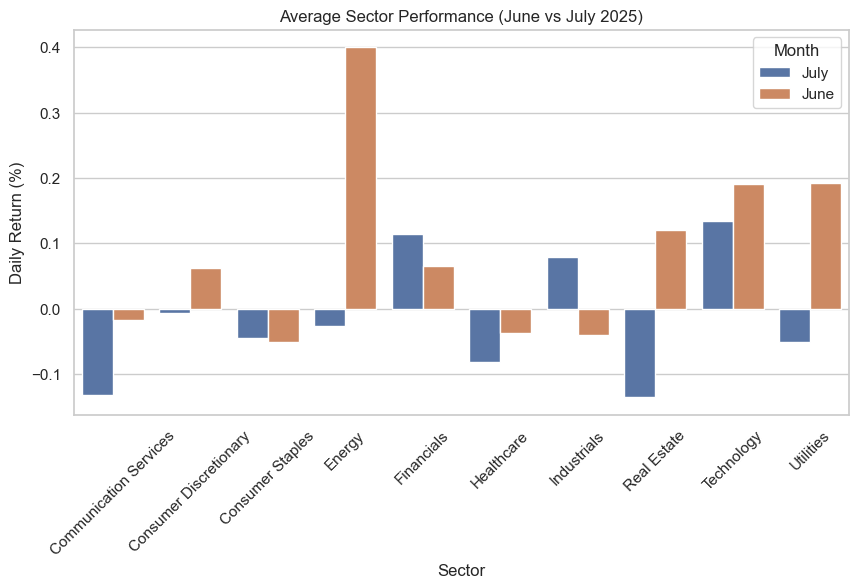

In [192]:
sector_perf = df.groupby(['Month', 'Sector'])['Daily Return (%)'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=sector_perf, x='Sector', y='Daily Return (%)', hue='Month')
plt.xticks(rotation=45)
plt.title("Average Sector Performance (June vs July 2025)")
plt.show()

#### 2. Which stocks had the highest and lowest monthly returns in each month?

In [65]:
top_gainers = df.groupby(['Month', 'Ticker'])['Daily Return (%)'].mean().reset_index()
top_gainers = top_gainers.sort_values(['Month','Daily Return (%)'], ascending=[True, False])

print("\nTop 5 Gainers Each Month:\n", top_gainers.groupby('Month').head(5))
print("\nBottom 5 Losers Each Month:\n", top_gainers.groupby('Month').tail(5))


Top 5 Gainers Each Month:
     Month Ticker  Daily Return (%)
36   July     KO          0.655527
30   July    IBM          0.598661
74   July    UNP          0.595702
53   July   ORCL          0.572071
51   July    NOW          0.549366
101  June    CRM          0.756161
114  June   INTU          0.702058
141  June   PYPL          0.644623
162  June    XOM          0.628631
154  June   UBER          0.545157

Bottom 5 Losers Each Month:
     Month Ticker  Daily Return (%)
55   July    PFE         -0.388193
14   July  BRK.B         -0.451508
27   July     GS         -0.465050
61   July   REGN         -0.477571
58   July     PM         -0.496646
105  June    ELV         -0.420526
136  June    PEP         -0.452701
108  June  GOOGL         -0.512374
94   June    BLK         -0.639304
107  June   GILD         -0.693298


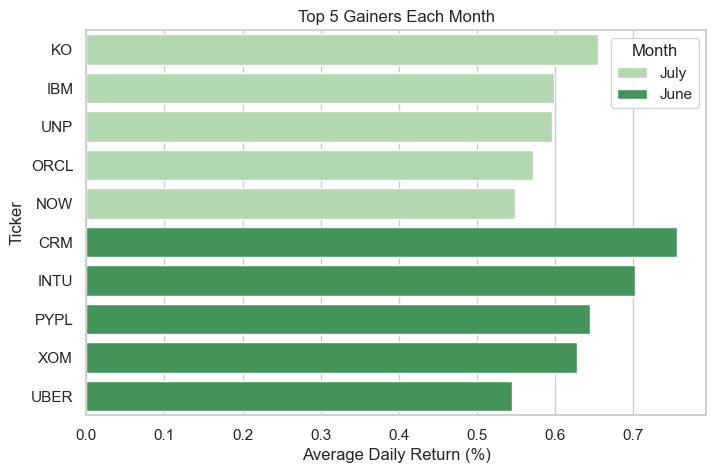

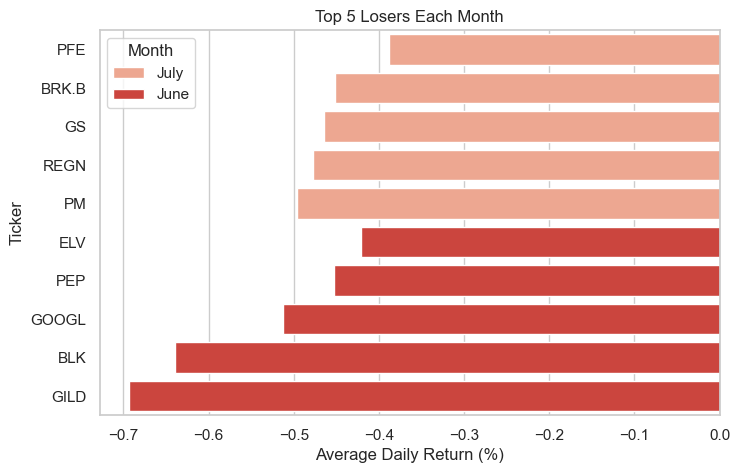

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Top 5 gainers per month
top5 = top_gainers.groupby('Month').head(5)

# Bottom 5 losers per month
bottom5 = top_gainers.groupby('Month').tail(5)

# Plot Top Gainers
plt.figure(figsize=(8,5))
sns.barplot(data=top5, x='Daily Return (%)', y='Ticker', hue='Month', palette='Greens')
plt.title("Top 5 Gainers Each Month")
plt.xlabel("Average Daily Return (%)")
plt.ylabel("Ticker")
plt.show()

# Plot Top Losers
plt.figure(figsize=(8,5))
sns.barplot(data=bottom5, x='Daily Return (%)', y='Ticker', hue='Month', palette='Reds')
plt.title("Top 5 Losers Each Month")
plt.xlabel("Average Daily Return (%)")
plt.ylabel("Ticker")
plt.show()

#### 3. Did market volatility increase or decrease from June to July across sectors?

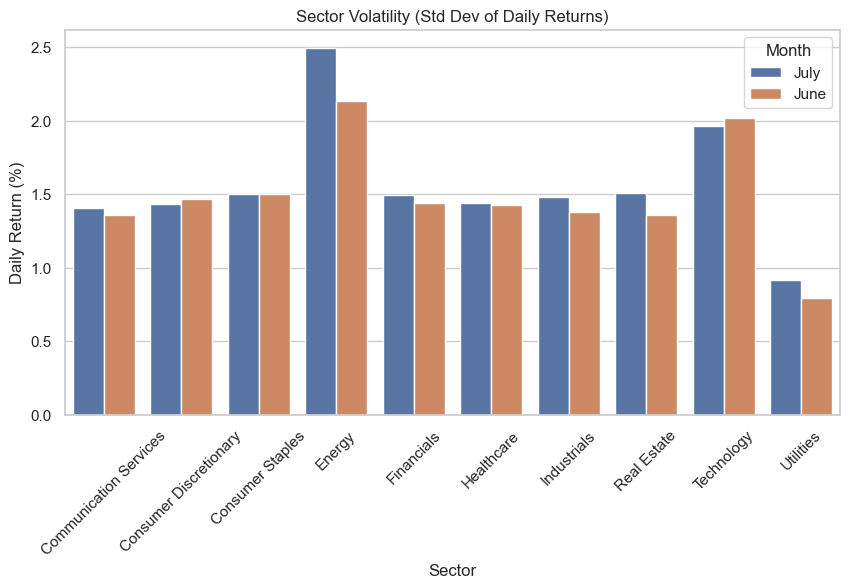

In [198]:
# RQ3 — Volatility Trends
volatility = df.groupby(['Month', 'Sector'])['Daily Return (%)'].std().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=volatility, x='Sector', y='Daily Return (%)', hue='Month')
plt.xticks(rotation=45)
plt.title("Sector Volatility (Std Dev of Daily Returns)")
plt.show()

#### 4. Is there a correlation between Market Cap and P/E Ratio?

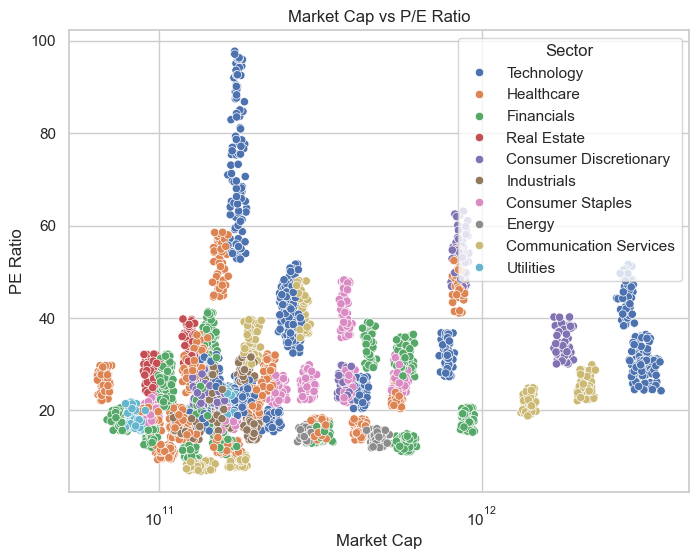


Correlation between Market Cap & P/E Ratio:
             Market Cap  PE Ratio
Market Cap    1.000000  0.194445
PE Ratio      0.194445  1.000000


In [201]:
# RQ4 — Market Cap vs P/E Ratio
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Market Cap', y='PE Ratio', hue='Sector')
plt.title("Market Cap vs P/E Ratio")
plt.xscale('log')
plt.show()

correlation = df[['Market Cap','PE Ratio']].corr()
print("\nCorrelation between Market Cap & P/E Ratio:\n", correlation)

#### 5. How did stock market volatility change between June and July 2025?”

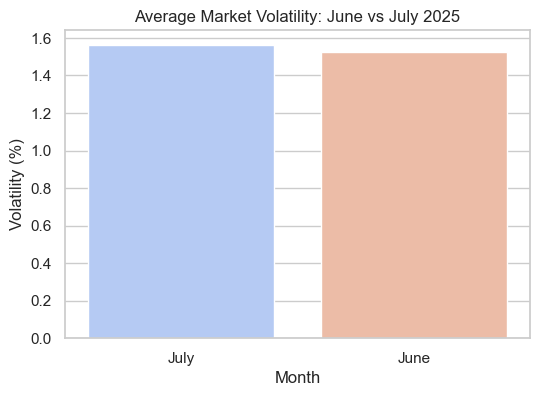

In [75]:
# Average volatility per month across all tickers
avg_vol_month = (
    vol_ticker_month.groupby('Month')['Volatility (%)']
    .mean()
    .reset_index()
)

# Plot average volatility trend
plt.figure(figsize=(6,4))
sns.barplot(
    data=avg_vol_month,
    x='Month',
    y='Volatility (%)',
    hue='Month',          # color by month
    palette='coolwarm',
    legend=False
)
plt.title("Average Market Volatility: June vs July 2025")
plt.ylabel("Volatility (%)")
plt.show()


#### 6. Did dividend-paying stocks outperform non-dividend stocks in this period?

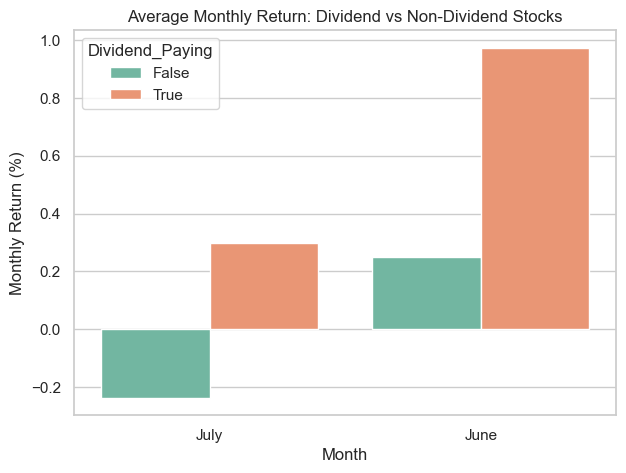

In [212]:
 # 1️⃣ Get latest snapshot per ticker
latest = df.sort_values(['Ticker', 'Date']).groupby('Ticker').last().reset_index()

# 2️⃣ Use the already engineered Dividend_Paying flag
# (no need to create Pays Dividend again)
latest = latest[['Ticker', 'Dividend_Paying']]

# 3️⃣ Merge with monthly returns dataset
monthly_div = monthly.merge(latest, on='Ticker', how='left')

# 4️⃣ Average monthly return by dividend status
avg_return_div = (
    monthly_div.groupby(['Month', 'Dividend_Paying'])['Monthly Return (%)']
    .mean()
    .reset_index()
)

# 5️⃣ Plot
plt.figure(figsize=(7,5))
sns.barplot(
    data=avg_return_div,
    x='Month',
    y='Monthly Return (%)',
    hue='Dividend_Paying',
    palette='Set2'
)
plt.title("Average Monthly Return: Dividend vs Non-Dividend Stocks")
plt.ylabel("Monthly Return (%)")
plt.xlabel("Month")
plt.show()

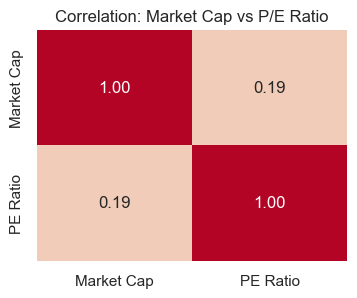

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[['Market Cap','PE Ratio']].corr()

plt.figure(figsize=(4,3))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, cbar=False)
plt.title("Correlation: Market Cap vs P/E Ratio")
plt.show()